# Non linear curve fitting with python

##### Germain Salvato Vallverdu [germain.vallverdu@univ-pau.fr](germain.vallverdu@univ-pau.fr)

This cookbook presents how to fit a non linear model on a set of data using python. Two kind of algorithms will be presented. First a standard least squares approach using the `curve_fit` fonction of `scipy.optimize` in which we will take into account the uncertaintes on the response, that is y. Second a fit with an orthogonal distance regression (ODR) using [`scipy.odr`](https://docs.scipy.org/doc/scipy/reference/odr.html) in which we will take into account both the uncertaintes on x and y.

## Python set up

In [1]:
# manage data and fit
import pandas as pd
import numpy as np

# first part with least squares
from scipy.optimize import curve_fit

# second part about ODR
from scipy.odr import ODR, Model, Data, RealData

# style and notebook integration of the plots
import seaborn as sns
%matplotlib inline 
sns.set(style="whitegrid")

## Read and plot data

Read the data from a csv file with pandas.

In [2]:
df = pd.read_csv("donnees_exo9.csv", sep=";")
df.head(8) # first 8 lines

x         y        Dy
0  0  1.371300 -0.021016
1  1  0.747050 -0.089438
2  2  0.587580  0.017098
3  3  0.510110  0.089353
4  4  0.424561  0.083885
5  5  0.394960  0.121319
6  6  0.157880 -0.152851
7  7  0.223860 -0.016393

Plot the data with error bars.

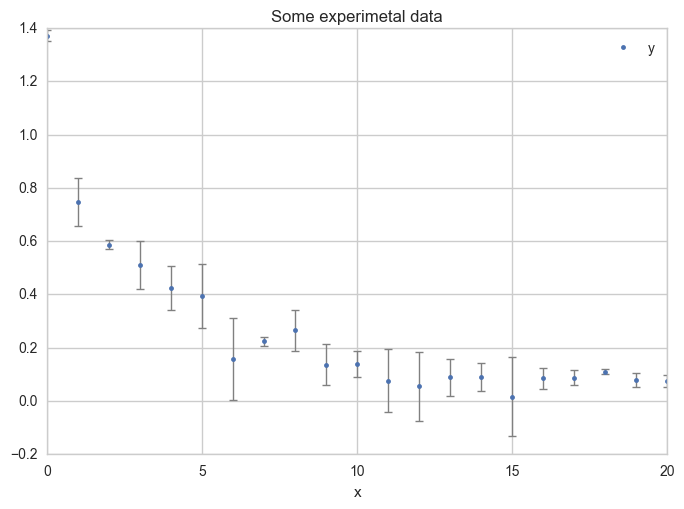

In [3]:
ax = df.plot(
    x="x", y="y",
    kind="line", yerr="Dy", title="Some experimetal data", 
    linestyle="", marker=".",
    capthick=1, ecolor="gray", linewidth=1
)

## Fit a model on the data

We want to fit the following model, with parameters, $a$ and $b$, on the above data.

$$f(x) = \ln \dfrac{(a + x)^2}{(x-c)^2}$$

### First step : the function

First, we define a function corresponding to the model :

In [4]:
def f_model(x, a, c):
    return pd.np.log((a + x)**2 / (x - c)**2)

### Second step : initialisation of parameters

Compute y values for the model with an estimate.

In [5]:
df["model"] = f_model(df["x"], 3, -2)
df.head(8)

x         y        Dy     model
0  0  1.371300 -0.021016  0.810930
1  1  0.747050 -0.089438  0.575364
2  2  0.587580  0.017098  0.446287
3  3  0.510110  0.089353  0.364643
4  4  0.424561  0.083885  0.308301
5  5  0.394960  0.121319  0.267063
6  6  0.157880 -0.152851  0.235566
7  7  0.223860 -0.016393  0.210721

Now plot your first estimation of the model.

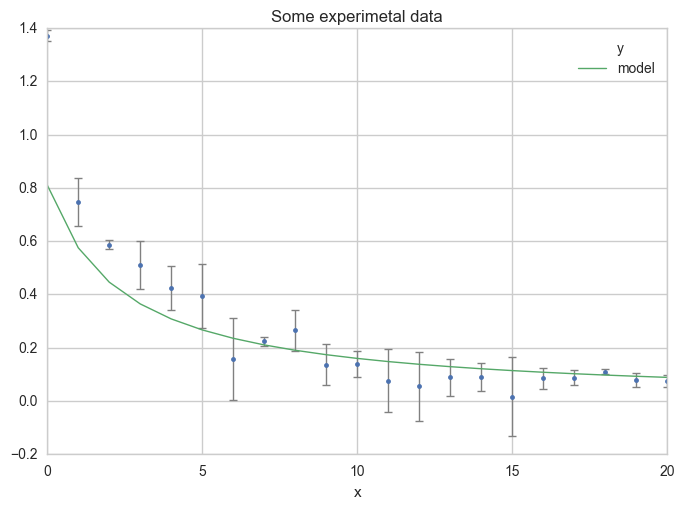

In [6]:
ax = df.plot(
    x="x", y="y",
    kind="line", yerr="Dy", title="Some experimetal data", 
    linestyle="", marker=".",
    capthick=1, ecolor="gray", linewidth=1
)
ax = df.plot(
    x="x", y="model",
    kind="line", ax=ax, linewidth=1
)

### Third step : Do the fit

Now we explicitely do the fit with `curve_fit` using our `f_model()` function and the initial guess for the parameters. Run `help(curve_fit)` and read the documentation about the function. `curve_fit` follow a least-square approach and will minimize :

$$\sum_k \dfrac{\left(f(\text{xdata}_k, \texttt{*popt}) - \text{ydata}_k\right)^2}{\sigma_k^2}$$

In [ ]:
help(curve_fit)

In [8]:
popt, pcov = curve_fit(
    f=f_model,       # model function
    xdata=df["x"],   # x data
    ydata=df["y"],   # y data
    p0=(3, -2),      # initial value of the parameters
    sigma=df["Dy"]   # uncertainties on y
)

In [9]:
print(popt)

[ 2.01673012 -1.01484118]


That's it !

### Fourth step : Results of the fit

Parameters are in  `popt` :

In [10]:
a_opt, c_opt = popt
print("a = ", a_opt)
print("c = ", c_opt)

a =  2.01673012047
c =  -1.01484117647


You can compute a standard deviation error from `pcov` :

In [11]:
perr = np.sqrt(np.diag(pcov))
Da, Dc = perr
print("a = %6.2f +/- %4.2f" % (a_opt, Da))
print("c = %6.2f +/- %4.2f" % (c_opt, Dc))

a =   2.02 +/- 0.06
c =  -1.01 +/- 0.03


You can compute the determination coefficient with :

\begin{equation}
    R^2 = \frac{\sum_k (y^{calc}_k - \overline{y})^2}{\sum_k (y_k - \overline{y})^2}
\end{equation}

In [12]:
R2 = np.sum((f_model(df.x, a_opt, c_opt) - df.y.mean())**2) / np.sum((df.y - df.y.mean())**2)
print("r^2 = %10.6f" % R2)

r^2 =   0.910600


### Make a plot

Now, see the results on a plot :

In [13]:
df["model"] = f_model(df.x, a_opt, c_opt)
df.head()

x         y        Dy     model
0  0  1.371300 -0.021016  1.373491
1  1  0.747050 -0.089438  0.807266
2  2  0.587580  0.017098  0.573842
3  3  0.510110  0.089353  0.445561
4  4  0.424561  0.083885  0.364284

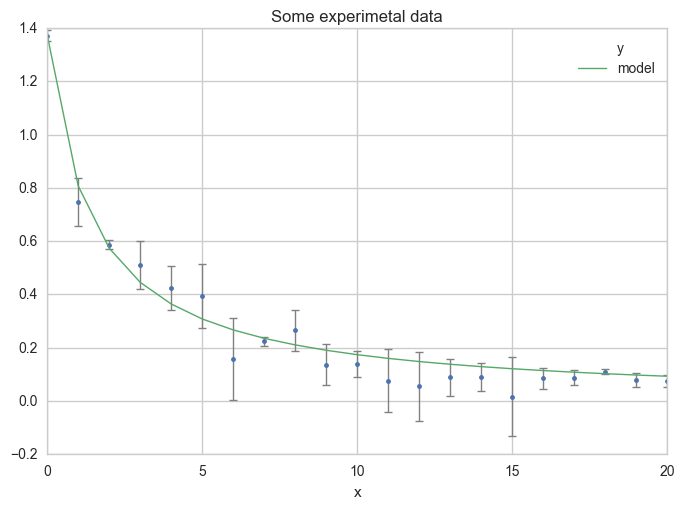

In [14]:
ax = df.plot(
    x="x", y="y",
    kind="line", yerr="Dy", title="Some experimetal data", 
    linestyle="", marker=".",
    capthick=1, ecolor="gray", linewidth=1
)
ax = df.plot(
    x="x", y="model",
    kind="line", ax=ax, linewidth=1
)

Or using more x values for the model, in order to get a smoother curve :

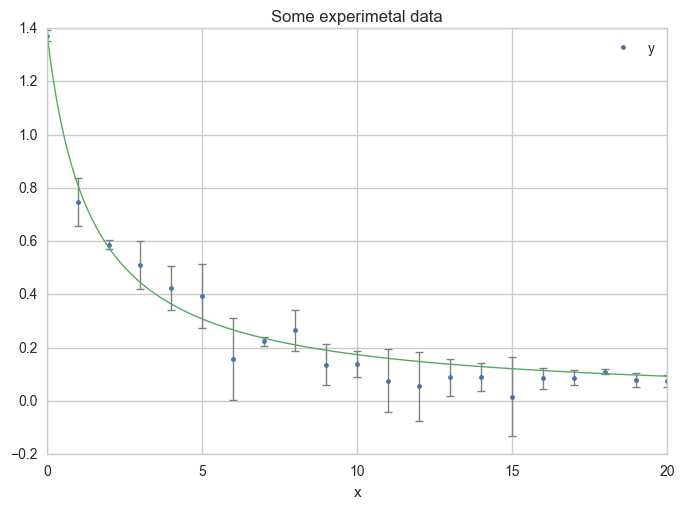

In [15]:
x = np.linspace(0, 20, 200)
ax = df.plot(
    x="x", y="y",
    kind="line", yerr="Dy", title="Some experimetal data", 
    linestyle="", marker=".",
    capthick=1, ecolor="gray", linewidth=1
)
ax.plot(x, f_model(x, a_opt, c_opt), linewidth=1)

## Uncertainties on both x and y

x and y are called the independant (or explanatory) and the dependant (the response) variables, respectively. As in the above example, uncertainties are often only take into account on the response variable (y). Here, we will do the same fit but with uncertainties on both x and y variables. 

In least square approches one minimizes, for each value of x, the distance between the response of the model and the data. As you do this for each specific value of x, you cannot include x uncetainties. In order to include them, we will use an orthogonal distance regression approach (ODR).
Look at [this stackoverflow question](http://stackoverflow.com/questions/26058792/correct-fitting-with-scipy-curve-fit-including-errors-in-x/26085136#26085136) from which the following was written.

### Add x uncertaintes

Add, artifically a random normal uncertainties on x.

In [16]:
nval = len(df)
del df["model"]
Dx = [np.random.normal(0.3, 0.2) for i in range(nval)]
df["Dx"] = Dx
df.head()

x         y        Dy        Dx
0  0  1.371300 -0.021016  0.091596
1  1  0.747050 -0.089438 -0.015025
2  2  0.587580  0.017098  0.230026
3  3  0.510110  0.089353 -0.113324
4  4  0.424561  0.083885  0.232209

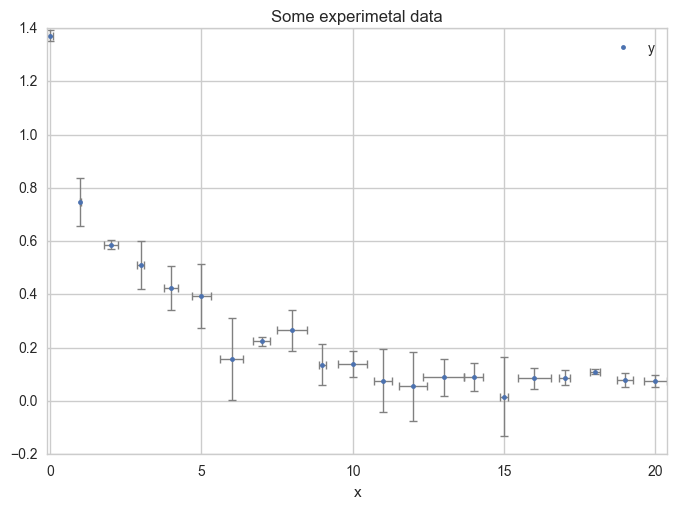

In [17]:
ax = df.plot(
    x="x", y="y",
    kind="line", yerr="Dy", xerr="Dx",
    title="Some experimetal data", 
    linestyle="", marker=".",
    capthick=1, ecolor="gray", linewidth=1
)

### Make the fits

#### 1) Define the model

The model function has to be define in a slight different way. The first argument (called `beta` here) must be the list of the parameters :

In [18]:
def fxy_model(beta, x):
    a, c = beta
    return pd.np.log((a + x)**2 / (x - c)**2)

Define the data and the model

In [19]:
data = RealData(df.x, df.y, df.Dx, df.Dy)
model = Model(fxy_model)

#### 2) Run the algorithms

Two calculations will be donne :

1. `fit_type=2` is a least squares approach and consider only y uncertainties.
2. `fit_type=0` explicit ODR

For each calculation, we make a first iteration and check if convergence is reached with `output.info`. If not we run at most 100 more time the algorithm while the convergence is not reached.

First you can see that the least squares approach gives the same results as the `curve_fit` function used above.

In [20]:
odr = ODR(data, model, [3, -2])
odr.set_job(fit_type=2)
lsq_output = odr.run()
print("Iteration 1:")
print("------------")
print("   stop reason:", lsq_output.stopreason)
print("        params:", lsq_output.beta)
print("          info:", lsq_output.info)
print("       sd_beta:", lsq_output.sd_beta)
print("sqrt(diag(cov):", np.sqrt(np.diag(lsq_output.cov_beta)))

# if convergence is not reached, run again the algorithm
if lsq_output.info != 1:
    print("\nRestart ODR till convergence is reached")
    i = 1
    while lsq_output.info != 1 and i < 100:
        print("restart", i)
        lsq_output = odr.restart()
        i += 1
    print("   stop reason:", lsq_output.stopreason)
    print("        params:", lsq_output.beta)
    print("          info:", lsq_output.info)
    print("       sd_beta:", lsq_output.sd_beta)
    print("sqrt(diag(cov):", np.sqrt(np.diag(lsq_output.cov_beta)))

Iteration 1:
------------
   stop reason: ['Sum of squares convergence']
        params: [ 2.01673013 -1.01484118]
          info: 1
       sd_beta: [ 0.0607908   0.03465753]
sqrt(diag(cov): [ 0.08244105  0.04700059]


In [21]:
a_lsq, c_lsq = lsq_output.beta
print("        ODR(lsq)    curve_fit")
print("------------------------------")
print("a = %12.7f %12.7f" % (a_lsq, a_opt))
print("c = %12.7f %12.7f" % (c_lsq, c_opt))

        ODR(lsq)    curve_fit
------------------------------
a =    2.0167301    2.0167301
c =   -1.0148412   -1.0148412


Now the explicit ODR approach with `fit_type=0`.

In [22]:
odr = ODR(data, model, [3, -2])
odr.set_job(fit_type=0)
odr_output = odr.run()
print("Iteration 1:")
print("------------")
print("   stop reason:", odr_output.stopreason)
print("        params:", odr_output.beta)
print("          info:", odr_output.info)
print("       sd_beta:", odr_output.sd_beta)
print("sqrt(diag(cov):", np.sqrt(np.diag(odr_output.cov_beta)))

# if convergence is not reached, run again the algorithm
if odr_output.info != 1:
    print("\nRestart ODR till convergence is reached")
    i = 1
    while odr_output.info != 1 and i < 100:
        print("restart", i)
        odr_output = odr.restart()
        i += 1
    print("   stop reason:", odr_output.stopreason)
    print("        params:", odr_output.beta)
    print("          info:", odr_output.info)
    print("       sd_beta:", odr_output.sd_beta)
    print("sqrt(diag(cov):", np.sqrt(np.diag(odr_output.cov_beta)))

# Print the results and compare to least square
a_odr, c_odr = odr_output.beta
print("\n        ODR(lsq)    curve_fit     True ODR")
print("--------------------------------------------")
print("a = %12.7f %12.7f %12.7f" % (a_lsq, a_opt, a_odr))
print("c = %12.7f %12.7f %12.7f" % (c_lsq, c_opt, c_odr))

Iteration 1:
------------
   stop reason: ['Sum of squares convergence']
        params: [ 1.94989375 -0.97864174]
          info: 1
       sd_beta: [ 0.11070806  0.0812683 ]
sqrt(diag(cov): [ 0.15857533  0.11640659]

        ODR(lsq)    curve_fit     True ODR
--------------------------------------------
a =    2.0167301    2.0167301    1.9498938
c =   -1.0148412   -1.0148412   -0.9786417


### Plot the results

Plot the different results.

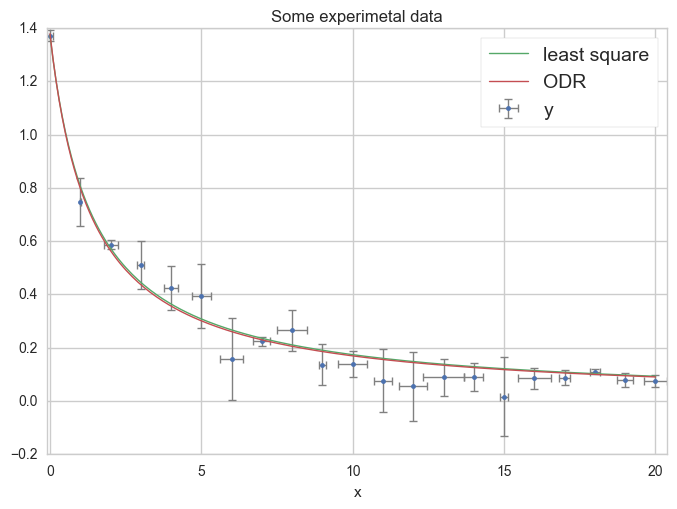

In [23]:
x = np.linspace(0, 20, 200)
ax = df.plot(
    x="x", y="y",
    kind="line", yerr="Dy", xerr="Dx",
    title="Some experimetal data", 
    linestyle="", marker=".",
    capthick=1, ecolor="gray", linewidth=1
)
ax.plot(x, f_model(x, a_lsq, c_lsq), linewidth=1, label="least square")
ax.plot(x, f_model(x, a_odr, c_odr), linewidth=1, label="ODR")
ax.legend(fontsize=14, frameon=True)

Although parameters are slightly different, the curves are almost superimposed.